In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

train = pd.read_csv("./train_set.csv")
test = pd.read_csv("./test_set.csv")

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25317 entries, 0 to 25316
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         25317 non-null  int64 
 1   age        25317 non-null  int64 
 2   job        25317 non-null  object
 3   marital    25317 non-null  object
 4   education  25317 non-null  object
 5   default    25317 non-null  object
 6   balance    25317 non-null  int64 
 7   housing    25317 non-null  object
 8   loan       25317 non-null  object
 9   contact    25317 non-null  object
 10  day        25317 non-null  int64 
 11  month      25317 non-null  object
 12  duration   25317 non-null  int64 
 13  campaign   25317 non-null  int64 
 14  pdays      25317 non-null  int64 
 15  previous   25317 non-null  int64 
 16  poutcome   25317 non-null  object
 17  y          25317 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 3.5+ MB


In [3]:
abs(train.corr()['y']).sort_values(ascending=False)

y           1.000000
ID          0.556627
duration    0.394746
pdays       0.107565
previous    0.088337
campaign    0.075173
balance     0.057564
day         0.031886
age         0.029916
Name: y, dtype: float64

In [4]:
s = (train.dtypes == 'object')
object_col = list(s[s].index)
object_col
num_col = list(set(train.columns) - set(object_col))
num_col

['pdays',
 'y',
 'previous',
 'duration',
 'age',
 'campaign',
 'ID',
 'balance',
 'day']

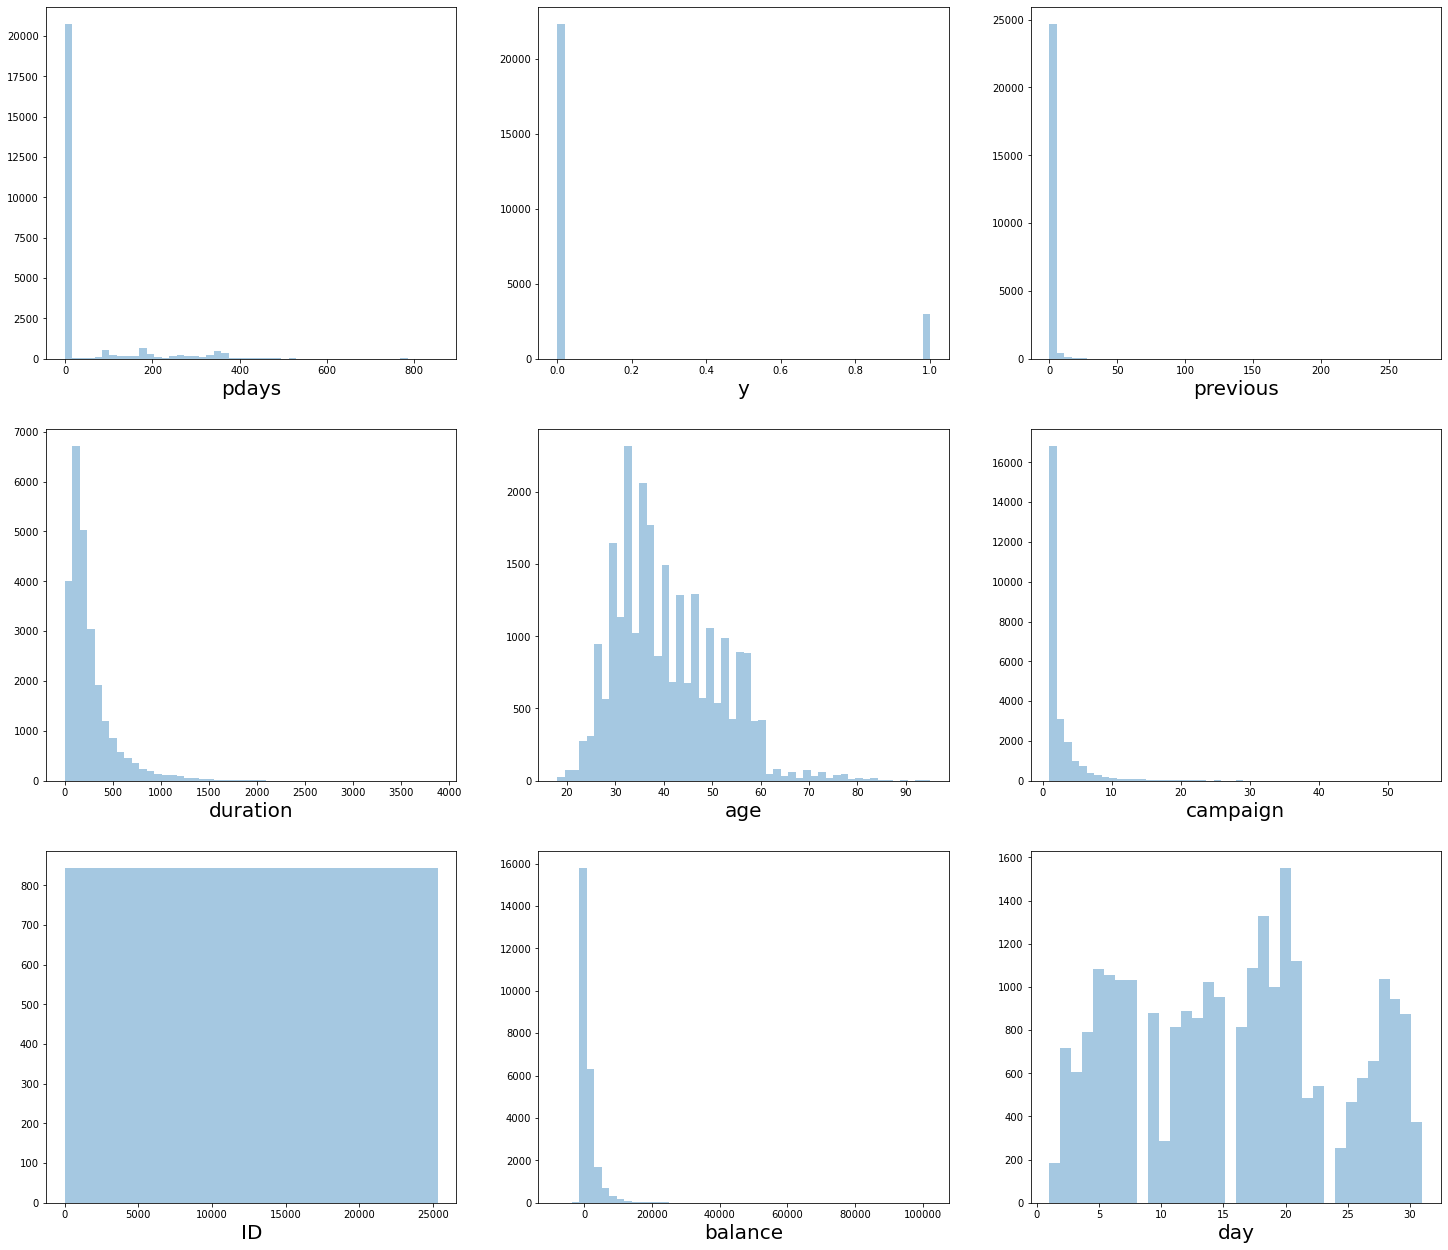

In [14]:
plt.figure(figsize=(25,22))
for (i,col) in enumerate(num_col):
    plt.subplot(3,3,i+1)
    sns.distplot(train[col], kde=False)
    plt.xlabel(col,size=20)
plt.show()  

In [17]:
X_train = train.drop(['ID','y'], axis=1)
X_test = test.drop(['ID'], axis=1)
y_train = train['y']
def num_cat_splitor(X_train):
    s = (X_train.dtypes == 'object')
    object_cols = list(s[s].index)
    num_cols = list(set(X_train.columns) - set(object_cols))
    return num_cols, object_cols
num_cols, object_cols = num_cat_splitor(X_train)


In [18]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
        
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_cols)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(object_cols)),
        ('cat_encoder', OneHotEncoder(sparse=False,handle_unknown='ignore')),
    ])
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
X_prepared = full_pipeline.fit_transform(X_train)

In [20]:
from sklearn.ensemble import RandomForestClassifier

prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('forst_reg', RandomForestClassifier(random_state=0))
])
param_grid = [{
#     'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'forst_reg__n_estimators' : [50,100, 150, 200,250,300,330,350],
    'forst_reg__max_features':[45,50, 55, 65]
}]

from sklearn.metrics import roc_auc_score
grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=7,
                                scoring='roc_auc', verbose=2, n_jobs=-1)


In [ ]:
grid_search_prep.fit(X_train,y_train)
grid_search_prep.best_params_
final_model = grid_search_prep.best_estimator_
y_pred_test = final_model.predict(X_test)
result = pd.DataFrame()
result['ID'] = test['ID']
result['pred'] = y_pred_test
result.to_csv('buy_product_pred.csv',index=False)

Fitting 7 folds for each of 32 candidates, totalling 224 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.2min
